In [1]:
import numpy as np
from skimage.io import imread
from skimage.color.colorconv import rgba2rgb
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from scipy.ndimage.filters import convolve

def calc_vseams(in_image, emap):
    n = in_image.shape[0]
    vseams = pd.DataFrame(np.zeros_like(emap))
    vseams.iloc[0] = emap[0, :]
    for i in range(1, n):
        vseams.iloc[i] = emap[i, :] + vseams.iloc[i - 1].rolling(window=3, min_periods=2, center=True).min()
    return vseams


def calculate_emap(image, mask=None):
    n, m = image.shape[0], image.shape[1]
    filter_dy = np.array([
        [1, 1, 1],
        [0, 0, 0],
        [-1, -1, -1]
    ])
    filter_dx = np.array([
        [1, 0, -1], 
        [1, 0, -1],
        [1, 0, -1]
    ])
    energy = np.zeros((n, m))
    for i in range(np.shape(image)[2]):
        energy += np.abs(convolve(image[:, :, i], filter_dy)) + np.abs(convolve(image[:, :, i], filter_dx))
    if mask is not None:
         energy[mask>0]= np.inf

    return energy

def calc_one_e1(image, i, j):
    n, m, _ = image.shape
    if i < 0 or j < 0 or i >= n or j >= m:
        return None

    a = image[i, j] if i == 0 else image[i - 1, j]
    b = image[i, j] if i == n - 1 else image[i + 1, j]
    c = image[i, j] if j == 0 else image[i, j - 1]
    d = image[i, j] if j == m - 1 else image[i, j + 1]

    return np.mean(abs(b - a) + abs(d - c), axis=-1)

def update_emap(emap, seam, new_image, remove=True, vertical=True):
    n, m, _ = new_image.shape
    new_emap = np.zeros((n, m))
    if vertical:
        for i in range(n):
            new_emap[i] = np.concatenate([emap[i, :seam[i]], emap[i, seam[i] + 1:]])
            e1_left = calc_one_e1(new_image, i, seam[i] - 1)
            if e1_left is not None:
                new_emap[i, seam[i] - 1] = e1_left
            e1_right = calc_one_e1(new_image, i, seam[i])
            if e1_right is not None:
                new_emap[i, seam[i]] = e1_right
    else:
        for i in range(m):
            new_emap[:, i] = np.concatenate([emap[:seam[i], i], emap[seam[i] + 1:, i]])
            e1_up = calc_one_e1(new_image, seam[i] - 1, i)
            if e1_up is not None:
                new_emap[seam[i] - 1, i] = e1_up
            e1_down = calc_one_e1(new_image, seam[i], i)
            if e1_down is not None:
                new_emap[seam[i], i] = e1_down

    return new_emap

def drop_vert_seam(in_image, emap=None, mask=None, required_new_emap=False):
    eps = 1e-4
    n, m, c = in_image.shape
    out_image = np.zeros((n, m - 1, c), np.int32)
    best_vseam = pd.Series(np.zeros(n, np.int32))

    if emap is None:
        emap = calculate_emap(in_image, mask)

    vseams = calc_vseams(in_image, emap)

    # write optimal seam path and out_image
    vseam_min = vseams.iloc[n - 1].argmin()
    best_vseam[n - 1] = vseam_min
    out_image[n - 1, :] = np.concatenate([in_image[n - 1, :vseam_min], in_image[n - 1, vseam_min + 1:]]) \
        if vseam_min < m else in_image[n - 1, :vseam_min]

    for i in range(n - 2, -1, -1):
        min_prev = vseams.iloc[i + 1, best_vseam[i + 1]] - emap[i + 1, best_vseam[i + 1]]
        j_min = max(0, best_vseam[i + 1] - 1)
        j_max = min(m - 1, best_vseam[i + 1] + 1)
        for j in range(j_min, j_max + 1):
            if vseams.iloc[i, j] - min_prev < eps:
                best_vseam[i] = j

                # write to out_image
                out_image[i, :] = np.concatenate([in_image[i, :j], in_image[i, j + 1:]]) if j < m \
                    else in_image[i, :j]
                break

    if required_new_emap:
        new_emap = update_emap(emap, best_vseam, out_image)
        return out_image, best_vseam, vseams.iloc[n - 1].min(), new_emap

    return out_image, best_vseam, vseams.iloc[n - 1].min()

def drop_horiz_seam(in_image, emap=None, mask=None, required_new_emap=False):
    n = np.shape(in_image)[0]
    in_image = np.rot90(in_image, 1, (1, 0))
    
    if emap is not None:
        emap = np.rot90(emap, 1, (1, 0))
    if mask is not None:
        mask = np.rot90(mask, 1, (1, 0))
    
    if required_new_emap:
        out_image, best_hseam, loc_min, new_emap = drop_vert_seam(in_image, emap, mask, required_new_emap) 
        return np.rot90(out_image, 1, (0, 1)), n - (best_hseam + 1), loc_min, np.rot90(new_emap, 1, (0, 1))
    else:
        out_image, best_hseam, loc_min = drop_vert_seam(in_image, emap, mask)
        return np.rot90(out_image, 1, (0, 1)), n - (best_hseam + 1), loc_min

def calc_tmap(in_image, r, c, mask=None):
    T = np.zeros((r + 1, c + 1), np.float64)

    P = np.zeros((r + 1, c + 1), np.int32)  # 1 - remove horiz seam, 0 - vert
    in_emap = calculate_emap(in_image, mask=mask)

    prev_images = dict()
    prev_images[(0, 0)] = (in_image, in_emap)

    for r0 in range(r + 1):
        for c0 in range(c + 1):
            if c0 == 0 and r0 == 0:
                continue

            if c0 == 0:  # drop horiz seam
                out_image, _, cost, out_emap = drop_horiz_seam(*prev_images[(r0 - 1, c0)],
                                                                       required_new_emap=True)
                T[r0, c0] = T[r0 - 1, c0] + cost
                P[r0, c0] = 1
                prev_images[(r0, c0)] = (out_image, out_emap)

            elif r0 == 0:  # drop vertical seam
                out_image, _, cost, out_emap = drop_vert_seam(*prev_images[(r0, c0 - 1)],
                                                                      required_new_emap=True)
                T[r0, c0] = T[r0, c0 - 1] + cost
                P[r0, c0] = 0
                prev_images[(r0, c0)] = (out_image, out_emap)

            else:
                out_vimage, _, vcost, out_vemap = drop_vert_seam(*prev_images[(r0 - 1, c0)],
                                                                          required_new_emap=True)
                out_himage, _, hcost, out_hemap = drop_horiz_seam(*prev_images[(r0, c0 - 1)],
                                                                           required_new_emap=True)

                vcost = T[r0, c0 - 1] + vcost
                hcost = T[r0 - 1, c0] + hcost

                if vcost <= hcost:
                    T[r0, c0] = vcost
                    P[r0, c0] = 1
                    prev_images[(r0, c0)] = (out_vimage, out_vemap)
                else:
                    T[r0, c0] = hcost
                    P[r0, c0] = 0
                    prev_images[(r0, c0)] = (out_himage, out_hemap)

    return T, P 

def retarget(in_image, n_new, m_new, mask=None):
    n, m, _ = in_image.shape
    r = n - n_new
    c = m - m_new

    emap = calculate_emap(in_image, mask=mask)
    tmap, pmap = calc_tmap(in_image, r, c, mask=mask)
    for i in range(r + c):
        if pmap[r, c] == 0:
            in_image, _, _, emap = drop_vert_seam(in_image, emap=emap, required_new_emap=True)
            c -= 1
        else:
            in_image, _, _, emap = drop_horiz_seam(in_image, emap=emap, required_new_emap=True)
            r -= 1

    return in_image

def add_vert_seam(in_image, seam):
    n, m, c = in_image.shape
    out_image = np.zeros((n, m + 1, c), np.int32)
    for i in range(n):
        out_image[i] = np.concatenate([in_image[i, :seam[i] + 1], in_image[i, seam[i]:]])
    return out_image

def add_horiz_seam(in_image, seam):
    n, m, c = in_image.shape
    out_image = np.zeros((n + 1, m, c), np.int32)
    for i in range(m):
        out_image[:, i] = np.concatenate([in_image[:seam[i] + 1, i], in_image[seam[i]:, i]])
    return out_image

def update_seams(seams):
    for idx, seam in enumerate(seams):
        for j in range(idx + 1, len(seams)):
            for i in range(len(seams[j])):
                if seams[j][i] >= seam[i]:
                    seams[j][i] += 1
    return seams

def enlarge_vert(in_image, m_large, mask=None):
    _, m, _ = in_image.shape
    r = m_large - m
    seams = []
    image = in_image
    emap = calculate_emap(in_image, mask=mask)

    for idx in range(r):
        image, best_vseam, _, emap = drop_vert_seam(image, emap=emap, required_new_emap=True)
        seams.append(best_vseam)

    seams = update_seams(seams)

    plt.imshow(in_image)
    for seam in seams:
        plot_vseam(in_image, seam, show=False)
    plt.show()

    seams = update_seams(seams)

    for idx, seam in enumerate(seams):
        in_image = add_vert_seam(in_image, seam)

    return in_image

def enlarge_horiz(in_image, n_large, mask=None):
    
    n, m, _ = in_image.shape
    c = n_large - n
    seams = []
    image = in_image
    emap = calculate_emap(in_image, mask=mask)

    for idx in range(c):
        image, best_hseam, _, emap = drop_horiz_seam(image, emap=emap, required_new_emap=True)
        seams.append(best_hseam)

    seams = update_seams(seams)

    plt.imshow(in_image)
    for seam in seams:
        plot_hseam(in_image, seam, show=False)
    plt.show()

    seams = update_seams(seams)
    
    for idx, seam in enumerate(seams):
        in_image = add_horiz_seam(in_image, seam)

    return in_image

def plot_hseam(in_image, seam, show=True):
    if show:
        plt.imshow(in_image)
    plt.plot(np.arange(in_image.shape[1]), seam, color="red")
    if show:
        plt.show()


def plot_vseam(in_image, seam, show=True):
    if show:
        plt.imshow(in_image)
    plt.plot(seam, np.arange(in_image.shape[0]), color="red")
    if show:
        plt.show()


def get_avail_resize(mask):
    mask_size = ((mask.sum(axis=1) > 0).sum() + 2, (mask.sum(axis=0) > 0).sum() + 2)
    r_max = max(0, mask.shape[0] - mask_size[0])
    c_max = max(0, mask.shape[1] - mask_size[1])
    print(f"Max available resize: {r_max, c_max}")
    return r_max, c_max


def read_mask(file_name):
    mask = imread(file_name)
    mask = rgba2rgb(mask) if mask.shape[-1] == 4 else mask

    return np.sum(mask, axis=-1) > 0

C:\Users\obars\AppData\Local\Temp/ipykernel_27364/3838225189.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


Max available resize: (60, 405)


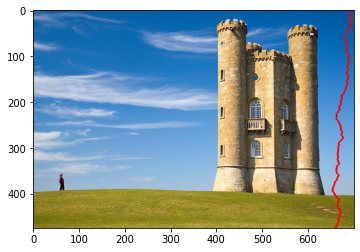

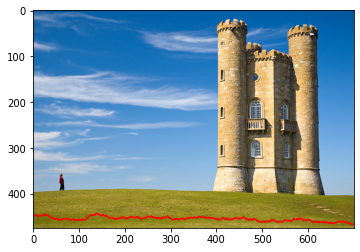

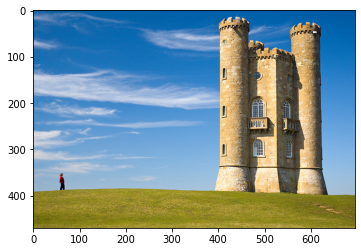

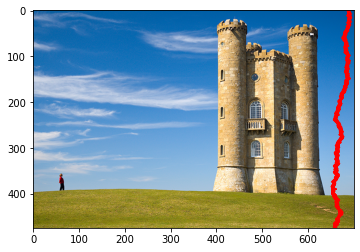

(475, 700, 3) (475, 710, 3)


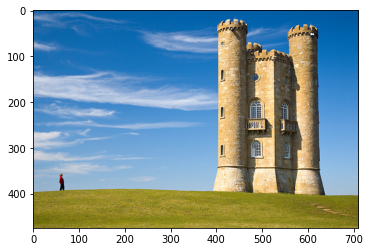

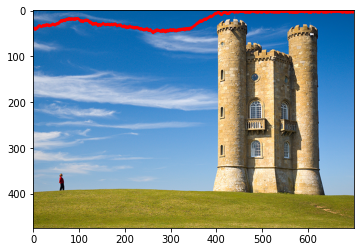

(475, 700, 3) (480, 700, 3)


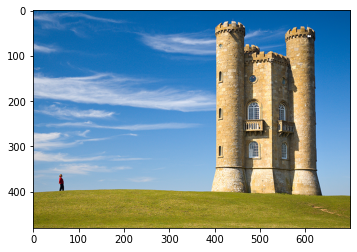

In [2]:
if __name__ == "__main__":
    image = imread("./seam_carve_data/01_input/img.png")
    ss_mask = read_mask("./seam_carve_data/01_input/mask.png")

    r_max, c_max = get_avail_resize(ss_mask)

    if c_max > 0:
        _, vseam, _ = drop_vert_seam(image, mask=ss_mask)
        plot_vseam(image, vseam)
    else:
        print("Vertical seam can't drop because of mask")

    if r_max > 0:
        _, hseam, _ = drop_horiz_seam(image, mask=ss_mask)
        plot_hseam(image, hseam)
    else:
        print("Horizontal seam can't drop because of mask")

    test_shape = (image.shape[0] - 5, image.shape[1] - 5, image.shape[2])
    if image.shape[0] - test_shape[0] <= r_max and image.shape[1] - test_shape[1] <= c_max:
        ret = retarget(image, test_shape[0], test_shape[1], mask=ss_mask)
        assert ret.shape == test_shape
        plt.imshow(ret)
        plt.show()
    else:
        print("Resizing isn't available, consider change r or c")

    m_large = image.shape[1] + 10
    enl_v = enlarge_vert(image, m_large, mask=ss_mask)
    print(image.shape, enl_v.shape)
    plt.imshow(enl_v)
    plt.show()

    n_large = image.shape[0] + 5
    enl_h = enlarge_horiz(image, n_large, mask=ss_mask)
    print(image.shape, enl_h.shape)
    plt.imshow(enl_h)
    plt.show()

In [ ]:
if c_max > 0:
    _, vseam, _ = drop_vert_seam(image, mask=ss_mask)
    plot_vseam(image, vseam)
else:
    print("Vertical seam can't drop because of mask")

if r_max > 0:
    _, hseam, _ = drop_horiz_seam(image, mask=ss_mask)
    plot_hseam(image, hseam)
else:
    print("Horizontal seam can't drop because of mask")

test_shape = (image.shape[0] - 5, image.shape[1] - 5, image.shape[2])
if image.shape[0] - test_shape[0] <= r_max and image.shape[1] - test_shape[1] <= c_max:
    ret = retarget(image, test_shape[0], test_shape[1], mask=ss_mask)
    assert ret.shape == test_shape
    plt.imshow(ret)
    plt.show()
else:
    print("Resizing isn't available, consider change r or c")

m_large = image.shape[1] + 10
enl_v = enlarge_vert(image, m_large, mask=ss_mask)
print(image.shape, enl_v.shape)
plt.imshow(enl_v)
plt.show()

n_large = image.shape[0] + 5
enl_h = enlarge_horiz(image, n_large, mask=ss_mask)
print(image.shape, enl_h.shape)
plt.imshow(enl_h)
plt.show()

In [ ]:
Оптимизация: 
    - адаптация функции подсчета энергии для 3х канального изображения (emap) 
    - исключение дублирования кода - повторения функций для нахождения оптимального горизонтального шва, 
       функции удаления горизонтального шва, и реализация соответствующих задач на основе функции для вертикальных швов 
        и повороте изображения на 90 градусов
построение энергетических карт с масками и без, реализация поворота изображения для нахождения шва, рефакторинг кода